# GSOM Jupyter platform optimizing project
## Read files (logs) from S3 with Spark

### 1. Libraries

In [1]:
import os
import sys
import json
import boto3
import logging
import psycopg2
import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import to_timestamp, year, month, dayofmonth, hour, minute, second, count, date_format
from pyspark.sql.functions import udf, struct, countDistinct
import multiprocessing
pd.set_option('display.max_columns', None)
N_CORES = min(
    multiprocessing.cpu_count(), 
    int(float(os.environ['CPU_LIMIT']))
)
print('max cores available:', N_CORES)

max cores available: 5


In [2]:
import os
if not os.path.exists("images"):
    os.mkdir("images")

### 2. Credentials and Spark settings

In [3]:
BUCKET = 'rawdata-test-timetable'
with open('access_jhub.json') as file:
    access_data = json.load(file)
access_data.keys()

dict_keys(['aws_access_key_id', 'aws_secret_access_key'])

In [4]:
print('user:', os.environ['JUPYTERHUB_SERVICE_PREFIX'])

def uiWebUrl(self):
    from urllib.parse import urlparse
    web_url = self._jsc.sc().uiWebUrl().get()
    port = urlparse(web_url).port
    return '{}proxy/{}/jobs/'.format(os.environ['JUPYTERHUB_SERVICE_PREFIX'], port)

SparkContext.uiWebUrl = property(uiWebUrl)

conf = SparkConf()
conf.set('spark.master', 'local[*]')
conf.set('spark.driver.memory', '8G')
conf.set('spark.driver.maxResultSize', '4G')
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
spark

user: /user/st102710/


23/06/01 09:45:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [5]:
spark._jsc.hadoopConfiguration().set('fs.s3a.access.key', access_data['aws_access_key_id'])
spark._jsc.hadoopConfiguration().set('fs.s3a.secret.key', access_data['aws_secret_access_key'])
spark._jsc.hadoopConfiguration().set('fs.s3a.impl','org.apache.hadoop.fs.s3a.S3AFileSystem')
spark._jsc.hadoopConfiguration().set('fs.s3a.multipart.size', '104857600')
spark._jsc.hadoopConfiguration().set('fs.s3a.block.size', '33554432')
spark._jsc.hadoopConfiguration().set('fs.s3a.threads.max', '256')
spark._jsc.hadoopConfiguration().set('fs.s3a.endpoint', 'http://storage.yandexcloud.net')

### 3. Structure of the timetable data

In [6]:
mask_files = 'events-2022-08-29-2023-02-06-2302022348.json'

In [7]:
sdf = spark.read.json(
    f's3a://{BUCKET}/{mask_files}',
    multiLine=True
)

23/06/01 09:45:19 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [8]:
sdf.count()

22400

In [9]:
sdf.printSchema()

root
 |-- AllDay: boolean (nullable = true)
 |-- ContingentUnitName: string (nullable = true)
 |-- ContingentUnitsDisplayTest: string (nullable = true)
 |-- DateWithTimeIntervalString: string (nullable = true)
 |-- DisplayDateAndTimeIntervalString: string (nullable = true)
 |-- DivisionAndCourse: string (nullable = true)
 |-- EducatorIds: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- Item1: long (nullable = true)
 |    |    |-- Item2: string (nullable = true)
 |-- EducatorsDisplayText: string (nullable = true)
 |-- EducatorsWereReassigned: boolean (nullable = true)
 |-- ElectiveDisciplinesCount: long (nullable = true)
 |-- End: string (nullable = true)
 |-- EventLocations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- DisplayName: string (nullable = true)
 |    |    |-- EducatorIds: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- Item1: long (null

In [10]:
sdf.limit(20).toPandas()

23/06/01 09:45:26 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,AllDay,ContingentUnitName,ContingentUnitsDisplayTest,DateWithTimeIntervalString,DisplayDateAndTimeIntervalString,DivisionAndCourse,EducatorIds,EducatorsDisplayText,EducatorsWereReassigned,ElectiveDisciplinesCount,End,EventLocations,HasEducators,HasTheSameTimeAsPreviousItem,IsAssigned,IsCancelled,IsElective,IsStudy,LocationsDisplayText,LocationsWereChanged,Start,StudyEventsTimeTableKindCode,Subject,TimeIntervalString,TimeWasChanged,WithinTheSameDay
0,False,,bachelor : Public Administration : 22.Б10-вшм,5 сентября 10:00–12:00,5 сентября 10:00–12:00,GSOM : 333103,"[(-1, Догот Т. В., старший преподаватель)]","Догот Т. В., старший преподаватель",False,1,2022-09-05T12:00:00,[(С использованием информационно-коммуникацион...,True,False,False,False,False,False,С использованием информационно-коммуникационны...,False,2022-09-05T10:00:00,0,Тестирование для распределения на траектории о...,10:00–12:00,False,False
1,False,,bachelor : Public Administration : 22.Б10-вшм,5 сентября 12:30–14:30,5 сентября 12:30–14:30,GSOM : 333103,"[(-1, Догот Т. В., старший преподаватель)]","Догот Т. В., старший преподаватель",False,1,2022-09-05T14:30:00,[(С использованием информационно-коммуникацион...,True,False,False,False,False,False,С использованием информационно-коммуникационны...,False,2022-09-05T12:30:00,0,Тестирование для распределения на траектории о...,12:30–14:30,False,False
2,False,,bachelor : Public Administration : 22.Б10-вшм,8 сентября 14:00–16:00,8 сентября 14:00–16:00,GSOM : 333103,"[(-1, Догот Т. В., старший преподаватель)]","Догот Т. В., старший преподаватель",False,1,2022-09-08T16:00:00,[(С использованием информационно-коммуникацион...,True,False,False,False,False,False,С использованием информационно-коммуникационны...,False,2022-09-08T14:00:00,0,Тестирование для распределения на траектории о...,14:00–16:00,False,False
3,False,,bachelor : Public Administration : 22.Б10-вшм,12 сентября 11:45–13:15,12 сентября 11:45–13:15,GSOM : 333103,"[(-1, Каминская А. В., ассистент)]","Каминская А. В., ассистент",False,1,2022-09-12T13:15:00,"[(Санкт-Петербургское шоссе, д. 109, лит. А,22...",True,False,False,False,False,False,"Санкт-Петербургское шоссе, д. 109, лит. А,2225",False,2022-09-12T11:45:00,0,Электив. Траектория 2 (А2 – В2). Английский яз...,11:45–13:15,False,False
4,False,,bachelor : Public Administration : 22.Б10-вшм,12 сентября 11:45–13:15,12 сентября 11:45–13:15,GSOM : 333103,"[(-1, Догот Т. В., старший преподаватель)]","Догот Т. В., старший преподаватель",False,1,2022-09-12T13:15:00,"[(Санкт-Петербургское шоссе, д. 109, лит. А,12...",True,False,False,False,False,False,"Санкт-Петербургское шоссе, д. 109, лит. А,1209",False,2022-09-12T11:45:00,0,Электив. Траектория 3 (В1 – В2). Английский яз...,11:45–13:15,False,False
5,False,,bachelor : Public Administration : 22.Б10-вшм,12 сентября 11:45–13:15,12 сентября 11:45–13:15,GSOM : 333103,"[(-1, Кузнецова М. С., ассистент)]","Кузнецова М. С., ассистент",False,1,2022-09-12T13:15:00,"[(Санкт-Петербургское шоссе, д. 109, лит. А,12...",True,False,False,False,False,False,"Санкт-Петербургское шоссе, д. 109, лит. А,1208",False,2022-09-12T11:45:00,0,Электив. Траектория 3 (В1 – В2). Английский яз...,11:45–13:15,False,False
6,False,,bachelor : Public Administration : 22.Б10-вшм,12 сентября 11:45–13:15,12 сентября 11:45–13:15,GSOM : 333103,"[(-1, Рогоза О. Н., старший преподаватель)]","Рогоза О. Н., старший преподаватель",False,1,2022-09-12T13:15:00,"[(Санкт-Петербургское шоссе, д. 109, лит. А,13...",True,False,False,False,False,False,"Санкт-Петербургское шоссе, д. 109, лит. А,1308",False,2022-09-12T11:45:00,0,Электив. Траектория 3 (В1 – В2). Английский яз...,11:45–13:15,False,False
7,False,,bachelor : Public Administration : 22.Б10-вшм,12 сентября 11:45–13:15,12 сентября 11:45–13:15,GSOM : 333103,"[(-1, Седова О. В., старший преподаватель)]","Седова О. В., старший преподаватель",False,1,2022-09-12T13:15:00,"[(Санкт-Петербургское шоссе, д. 109, лит. А,13...",True,False,False,False,False,False,"Санкт-Петербур

In [11]:
course_df = sdf.select("Subject").distinct().toPandas()

# Convert the course list or DataFrame to a Pandas DataFrame
df = pd.DataFrame(course_df, columns=["Subject"])  # Use "course_df" if you have a DataFrame

# Export the DataFrame to an Excel file
df.to_excel("course_list.xlsx", index=False)

In [12]:
dfa = sdf.toPandas()

dfa.to_excel("full_list.xlsx", index=False)

In [13]:
mask_files = 'events-2022-08-29-2023-02-06-2302022348.json'

In [14]:
sdf = spark.read.json(
    f's3a://{BUCKET}/{mask_files}',
    multiLine=True
)

In [15]:
sdf.count()

22400

In [16]:
sdf.printSchema()

root
 |-- AllDay: boolean (nullable = true)
 |-- ContingentUnitName: string (nullable = true)
 |-- ContingentUnitsDisplayTest: string (nullable = true)
 |-- DateWithTimeIntervalString: string (nullable = true)
 |-- DisplayDateAndTimeIntervalString: string (nullable = true)
 |-- DivisionAndCourse: string (nullable = true)
 |-- EducatorIds: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- Item1: long (nullable = true)
 |    |    |-- Item2: string (nullable = true)
 |-- EducatorsDisplayText: string (nullable = true)
 |-- EducatorsWereReassigned: boolean (nullable = true)
 |-- ElectiveDisciplinesCount: long (nullable = true)
 |-- End: string (nullable = true)
 |-- EventLocations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- DisplayName: string (nullable = true)
 |    |    |-- EducatorIds: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- Item1: long (null

In [17]:
sdf.limit(5).toPandas()

,AllDay,ContingentUnitName,ContingentUnitsDisplayTest,DateWithTimeIntervalString,DisplayDateAndTimeIntervalString,DivisionAndCourse,EducatorIds,EducatorsDisplayText,EducatorsWereReassigned,ElectiveDisciplinesCount,End,EventLocations,HasEducators,HasTheSameTimeAsPreviousItem,IsAssigned,IsCancelled,IsElective,IsStudy,LocationsDisplayText,LocationsWereChanged,Start,StudyEventsTimeTableKindCode,Subject,TimeIntervalString,TimeWasChanged,WithinTheSameDay
0,False,,bachelor : Public Administration : 22.Б10-вшм,5 сентября 10:00–12:00,5 сентября 10:00–12:00,GSOM : 333103,"[(-1, Догот Т. В., старший преподаватель)]","Догот Т. В., старший преподаватель",False,1,2022-09-05T12:00:00,[(С использованием информационно-коммуникацион...,True,False,False,False,False,False,С использованием информационно-коммуникационны...,False,2022-09-05T10:00:00,0,Тестирование для распределения на траектории о...,10:00–12:00,False,False
1,False,,bachelor : Public Administration : 22.Б10-вшм,5 сентября 12:30–14:30,5 сентября 12:30–14:30,GSOM : 333103,"[(-1, Догот Т. В., старший преподаватель)]","Догот Т. В., старший преподаватель",False,1,2022-09-05T14:30:00,[(С использованием информационно-коммуникацион...,True,False,False,False,False,False,С использованием информационно-коммуникационны...,False,2022-09-05T12:30:00,0,Тестирование для распределения на траектории о...,12:30–14:30,False,False
2,False,,bachelor : Public Administration : 22.Б10-вшм,8 сентября 14:00–16:00,8 сентября 14:00–16:00,GSOM : 333103,"[(-1, Догот Т. В., старший преподаватель)]","Догот Т. В., старший преподаватель",False,1,2022-09-08T16:00:00,[(С использованием информационно-коммуникацион...,True,False,False,False,False,False,С использованием информационно-коммуникационны...,False,2022-09-08T14:00:00,0,Тестирование для распределения на траектории о...,14:00–16:00,False,False
3,False,,bachelor : Public Administration : 22.Б10-вшм,12 сентября 11:45–13:15,12 сентября 11:45–13:15,GSOM : 333103,"[(-1, Каминская А. В., ассистент)]","Каминская А. В., ассистент",False,1,2022-09-12T13:15:00,"[(Санкт-Петербургское шоссе, д. 109, лит. А,22...",True,False,False,False,False,False,"Санкт-Петербургское шоссе, д. 109, лит. А,2225",False,2022-09-12T11:45:00,0,Электив. Траектория 2 (А2 – В2). Английский яз...,11:45–13:15,False,False
4,False,,bachelor : Public Administration : 22.Б10-вшм,12 сентября 11:45–13:15,12 сентября 11:45–13:15,GSOM : 333103,"[(-1, Догот Т. В., старший преподаватель)]","Догот Т. В., старший преподаватель",False,1,2022-09-12T13:15:00,"[(Санкт-Петербургское шоссе, д. 109, лит. А,12...",True,False,False,False,False,False,"Санкт-Петербургское шоссе, д. 109, лит. А,1209",False,2022-09-12T11:45:00,0,Электив. Траектория 3 (В1 – В2). Английский яз...,11:45–13:15,False,False


In [18]:
sdf = sdf.withColumn('Start', to_timestamp('Start', 'yyyy-MM-dd\'T\'HH:mm:ss'))
sdf = sdf.withColumn('End', to_timestamp('End', 'yyyy-MM-dd\'T\'HH:mm:ss'))
print("Converted 'Start' and 'End' timestamp strings to datetime objects:")
sdf.select('Start', 'End').show(5)

Converted 'Start' and 'End' timestamp strings to datetime objects:
+-------------------+-------------------+
|              Start|                End|
+-------------------+-------------------+
|2022-09-05 10:00:00|2022-09-05 12:00:00|
|2022-09-05 12:30:00|2022-09-05 14:30:00|
|2022-09-08 14:00:00|2022-09-08 16:00:00|
|2022-09-12 11:45:00|2022-09-12 13:15:00|
|2022-09-12 11:45:00|2022-09-12 13:15:00|
+-------------------+-------------------+
only showing top 5 rows



In [19]:
sdf = sdf.withColumn('StartYear', year('Start'))
sdf = sdf.withColumn('StartMonth', month('Start'))
sdf = sdf.withColumn('StartMonthName', date_format('Start', 'MMMM'))  # Use 'MMMM' to get the full month name
sdf = sdf.withColumn('StartDay', dayofmonth('Start'))
sdf = sdf.withColumn('StartHour', hour('Start'))
sdf = sdf.withColumn('StartMinute', minute('Start'))
sdf = sdf.withColumn('StartDayOfWeek', date_format('Start', 'EEEE'))

print("Extracted time components from the 'Start' datetime:")
sdf.select('StartYear', 'StartMonth', 'StartMonthName', 'StartDay', 'StartHour', 'StartMinute', 'StartDayOfWeek').show(50)

Extracted time components from the 'Start' datetime:
+---------+----------+--------------+--------+---------+-----------+--------------+
|StartYear|StartMonth|StartMonthName|StartDay|StartHour|StartMinute|StartDayOfWeek|
+---------+----------+--------------+--------+---------+-----------+--------------+
|     2022|         9|     September|       5|       10|          0|        Monday|
|     2022|         9|     September|       5|       12|         30|        Monday|
|     2022|         9|     September|       8|       14|          0|      Thursday|
|     2022|         9|     September|      12|       11|         45|        Monday|
|     2022|         9|     September|      12|       11|         45|        Monday|
|     2022|         9|     September|      12|       11|         45|        Monday|
|     2022|         9|     September|      12|       11|         45|        Monday|
|     2022|         9|     September|      12|       11|         45|        Monday|
|     2022|         9| 

In [20]:
daily_activities = sdf.groupBy('StartYear', 'StartMonth', 'StartMonthName', 'StartDay', 'StartDayOfWeek').agg(count('*').alias('ActivityCount'))
print("Grouped by year, month, day, and day of the week, and counted the events:")
daily_activities.show()

Grouped by year, month, day, and day of the week, and counted the events:


+---------+----------+--------------+--------+--------------+-------------+
|StartYear|StartMonth|StartMonthName|StartDay|StartDayOfWeek|ActivityCount|
+---------+----------+--------------+--------+--------------+-------------+
|     2022|        12|      December|       5|        Monday|          394|
|     2022|         9|     September|      30|        Friday|          165|
|     2022|        12|      December|      21|     Wednesday|          143|
|     2022|         9|     September|      26|        Monday|          334|
|     2022|        11|      November|      21|        Monday|          401|
|     2022|        10|       October|      31|        Monday|          406|
|     2022|         9|     September|      24|      Saturday|          109|
|     2022|         9|     September|      27|       Tuesday|          215|
|     2022|        10|       October|      29|      Saturday|          185|
|     2022|         9|     September|       9|        Friday|           70|
|     2023| 

In [21]:
monthly_activities = sdf.groupBy('StartYear', 'StartMonth', 'StartMonthName', 'StartDayOfWeek').agg(count('*').alias('ActivityCount'))
print("Grouped by year, month, and day of the week, and counted the events:")
monthly_activities.show()

Grouped by year, month, and day of the week, and counted the events:
+---------+----------+--------------+--------------+-------------+
|StartYear|StartMonth|StartMonthName|StartDayOfWeek|ActivityCount|
+---------+----------+--------------+--------------+-------------+
|     2022|         9|     September|     Wednesday|          228|
|     2022|        10|       October|        Monday|         1780|
|     2022|         9|     September|        Friday|          520|
|     2022|         9|     September|      Thursday|         1340|
|     2022|        12|      December|        Friday|          686|
|     2022|        11|      November|      Thursday|         1646|
|     2022|        12|      December|      Saturday|          568|
|     2023|         2|      February|     Wednesday|           42|
|     2022|        10|       October|      Thursday|         1549|
|     2022|        11|      November|       Tuesday|         1234|
|     2022|        10|       October|     Wednesday|        

/tmp/ipykernel_782/2485587420.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(hourly_count.index.strftime('%H:%M'), rotation=90)
/tmp/ipykernel_782/2485587420.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
/tmp/ipykernel_782/2485587420.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(['', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])


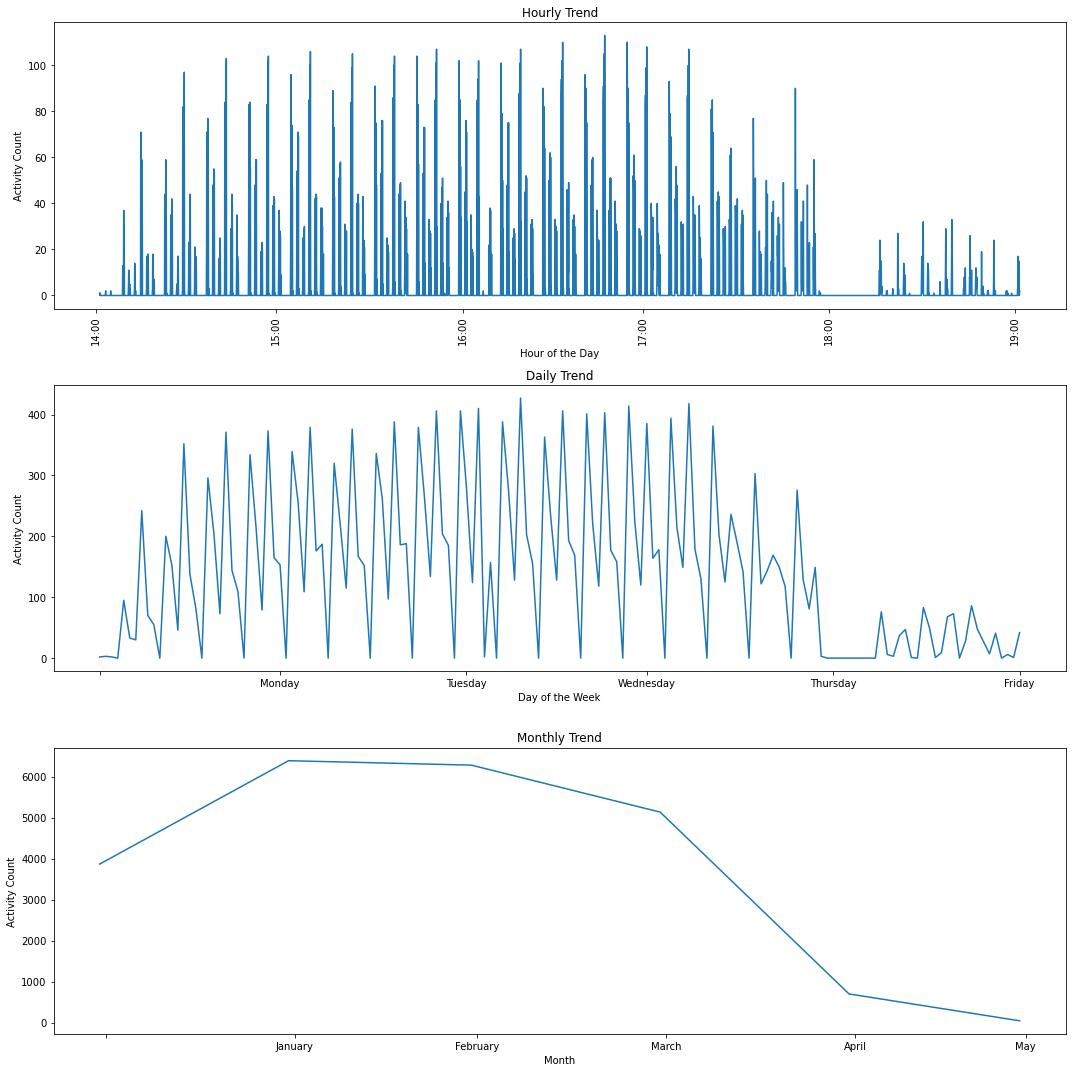

In [22]:
pdf = sdf.toPandas()
pdf.set_index('Start', inplace=True)
activity_column = 'StartYear'


hourly_count = pdf.resample('H').count()[activity_column]
daily_count = pdf.resample('D').count()[activity_column]
monthly_count = pdf.resample('M').count()[activity_column]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

ax1.plot(hourly_count)
ax1.set_title('Hourly Trend')
ax1.set_xlabel('Hour of the Day')
ax1.set_xticklabels(hourly_count.index.strftime('%H:%M'), rotation=90)
ax1.set_ylabel('Activity Count')

ax2.plot(daily_count)
ax2.set_title('Daily Trend')
ax2.set_xlabel('Day of the Week')
ax2.set_xticklabels(['', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax2.set_ylabel('Activity Count')

ax3.plot(monthly_count)
ax3.set_title('Monthly Trend')
ax3.set_xlabel('Month')
ax3.set_xticklabels(['', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
ax3.set_ylabel('Activity Count')

plt.tight_layout()
plt.show()

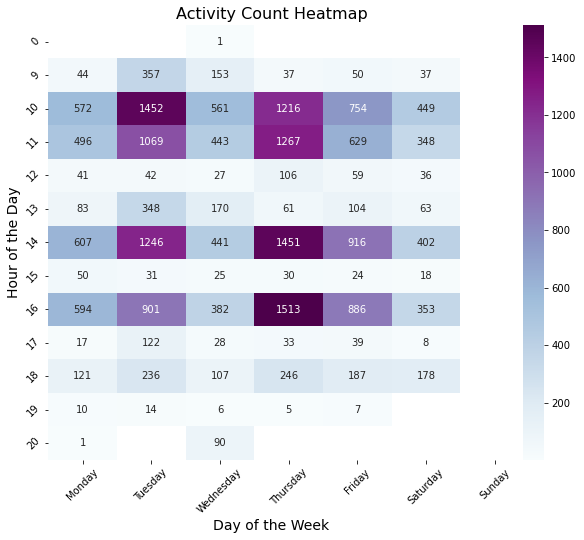

In [23]:
pivot_table = pd.pivot_table(
    pdf,
    index='StartHour',
    columns='StartDayOfWeek',
    values='StartYear',
    aggfunc='count'
)

day_of_week_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, cmap='BuPu', annot=True, fmt='.0f', xticklabels=day_of_week_names)
plt.title('Activity Count Heatmap', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Hour of the Day', fontsize=14)
plt.savefig('heatmap3.png', dpi=300, bbox_inches='tight')